In [298]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [299]:
ENV_SIZE = 16
INITIAL_POSITION = 0
FOOD_POSITION = 8
MOVEMENT_PROBABILITY = 0.75

# Sensory dynamics parameters
MAX_SENSE_PROBABILITY = 4**(-1/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega

# Number of epochs (simulation steps).
EPOCHS = 100

# Number of gradient descent steps made to update beliefs in each epoch.
N_STEPS = 100
LEARNING_RATE = 0.8

# No preference for position
#DESIRED_POSITIONS = [0.0] * ENV_SIZE

# Fuzzy preference distributed around a specified position.
pos = 2
rng = np.arange(ENV_SIZE)
DESIRED_POSITIONS = MAX_SENSE_PROBABILITY * np.exp(-SENSE_DECAY_RATE * np.minimum((rng - pos) % ENV_SIZE,
                                                                                  (pos - rng) % ENV_SIZE))

In [300]:
tf.reset_default_graph()

# Position (external state), Psi \in (0,15)
Psi = tf.Variable(initial_value=INITIAL_POSITION, trainable=False, dtype=tf.int32, name='external')

# Sensory state, S \in {0, 1}
S = tf.Variable(initial_value=1, trainable=False, dtype=tf.int32, name='sensory')

# Action state, A \in {-1, 1}
A = tf.Variable(initial_value=1, trainable=False, dtype=tf.int32, name='action')

# Internal state, R \in R^16
R = tf.Variable(initial_value=[0.0]*ENV_SIZE, trainable=False, dtype=tf.float32, name='internal')

# Internal state (as intention), Ri \in R^16
Ri = tf.Variable(initial_value=DESIRED_POSITIONS, trainable=False, dtype=tf.float32, name='internal_intention')

# Internal state (as belief), Rb \in R^16
Rb = tf.Variable(initial_value=[0.0]*ENV_SIZE, trainable=True, dtype=tf.float32, name='internal_belief')


def environmental_dynamics(psi, a):
    """
    P(Psi' | Psi, A)
    Probability of a new position given the old position and selected action.
    """
    return tf.scatter_nd(tf.cast([[psi % ENV_SIZE], [(psi + a) % ENV_SIZE]], tf.int32),
                         tf.stack([1 - MOVEMENT_PROBABILITY, MOVEMENT_PROBABILITY]),
                         [ENV_SIZE])


def sensory_dynamics(psi):
    """
    P(S | Psi)
    Probability of experiencing sensory state 1 given current position.
    """
    return MAX_SENSE_PROBABILITY * tf.exp(-SENSE_DECAY_RATE * tf.cast(
                        tf.minimum((psi - FOOD_POSITION) % ENV_SIZE,
                                   (FOOD_POSITION - psi) % ENV_SIZE),
                        tf.float32))


def model_encoding(R):
    """
    Probability of occupying specific position as encoded in the internal state.
    """
    return tf.nn.softmax(R)


def generative_density(R, a):
    """
    P(Psi', S | R, A)
    Agent's prediction of its new position given its internal state and selected action
    (calculated separately for two sensory states).
    """
    return tf.stack([
        tf.reduce_sum(
            tf.stack([environmental_dynamics(psi, a) * (1-sensory_dynamics(psi)) * model_encoding(R)[psi]
                      for psi in range(ENV_SIZE)], axis=0), axis=0),
        tf.reduce_sum(
            tf.stack([environmental_dynamics(psi, a) * sensory_dynamics(psi) * model_encoding(R)[psi]
                      for psi in range(ENV_SIZE)], axis=0), axis=0)])


def variational_density(R):
    """
    P(Psi | R)
    Agent's belief about the external states (i.e. its current position in the 
    world) or intention (i.e. desired position in the world) as encoded in the
    internal state.
    """
    return model_encoding(R)


def KL(a, b):
    """
    Kullback-Leibler divergence between densities a and b.
    """
    return tf.reduce_sum(a * tf.log(a/b))


def free_energy(R1, R, s, a):
    """
    KL divergence between variational density and generative density for a fixed
    sensory state s.
    """
    return KL(variational_density(R1), generative_density(R, a)[s])


update_sensor = S.assign(tf.cond(tf.less(tf.random_uniform([1])[0], sensory_dynamics(Psi)), lambda: 1, lambda: 0))
choose_action = A.assign(tf.cond(tf.less(free_energy(Ri, R, S, -1), free_energy(Ri, R, S, 1)), lambda: -1, lambda: 1))

clear_belief = Rb.assign(tf.constant([0.0]*16))
update_belief = R.assign(Rb)

update_position = Psi.assign(tf.cond(tf.less(tf.random_uniform([1])[0], MOVEMENT_PROBABILITY),
                                     lambda: (Psi + A) % ENV_SIZE, lambda: Psi))

belief_optimizer_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(free_energy(Rb, R, S, A))

In [301]:
# Initializing the variables
init = tf.global_variables_initializer()

Psi_trace = []
R_trace = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(EPOCHS):
        sess.run([update_sensor, choose_action, clear_belief])
        for step in range(N_STEPS):
            sess.run(belief_optimizer_step)
        sess.run([update_belief, update_position]) 
        
        Psi_trace.append(Psi.eval())
        R_trace.append(R.eval())

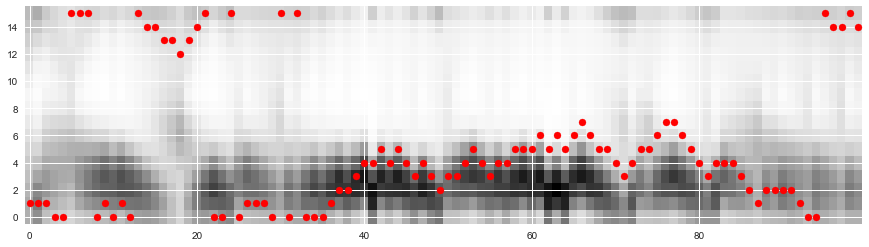

In [302]:
fig = plt.figure(figsize=(15, 4))
ax = fig.gca()

ax.imshow(np.exp(R_trace).T / np.sum(np.exp(R_trace), axis=1), interpolation="nearest", aspect="auto")
ax.scatter(list(range(EPOCHS)), Psi_trace, color="red")
ax.invert_yaxis()